In [11]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

from jax.experimental.ode import odeint

In [12]:
# def rhs(y,t):
#   return [1.5 * y[0] - 1.0 * y[0] * y[1],-2.0 * y[1] + 0.5 * y[0] * y[1]]

# ts = jnp.arange(0,10.,1)

# data = odeint(rhs,y0 = jnp.array([1.,1.]),t = ts)

# plt.plot(ts,data)

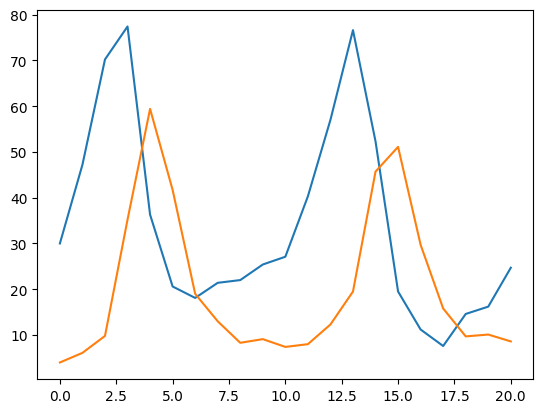

In [13]:


ts = jnp.arange(0,21.,1)

hare = jnp.array([30, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22, 25.4, 27.1, 40.3, 57, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
lynx = jnp.array([4, 6.1, 9.8, 35.2, 59.4, 41.7, 19, 13, 8.3, 9.1, 7.4, 8, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])

data = jnp.stack((hare,lynx)).T

plt.plot(data)


In [14]:
class Func(eqx.Module):
    par: jnp.array

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.par = jnp.array([0.4,0.018,0.8,0.023])

    def __call__(self, t, y, args):
        return jnp.array([self.par[0] * y[0] - self.par[1] * y[0] * y[1], - self.par[2] * y[1] + self.par[3] * y[0] * y[1]]).reshape(-1)

In [15]:
class LV(eqx.Module):
    func: Func

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.func = Func()


    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [16]:
model = LV()

In [17]:
@eqx.filter_jit
def make_step(network,state):

  loss_val,grad = eqx.filter_value_and_grad(loss)(network)
  updates, new_state = optimizer.update(grad, state, network)
  new_network = eqx.apply_updates(network,updates)

  return new_network,new_state,loss_val

In [18]:
def loss(network):
    return jnp.mean((network(ts,data[0,:]) - data)**2)

In [19]:
##Training loop

epochs = 1000
learning_rate = 0.001

optimizer = optax.rmsprop(learning_rate)

opt_state = optimizer.init(eqx.filter(model,eqx.is_array))


loss_history = []

for i in range(epochs):
  model,opt_state,loss_value = make_step(model,opt_state)
  model = eqx.tree_at(lambda m: m.func.par, model, jnp.clip(model.func.par, 0.0, 1.0))
  loss_history.append(loss_value)

  if i % 100 == 0:
    print(f"Epoch {i}: loss = {loss_value}")

model (21, 2)
true (21, 2)
Epoch 0: loss = 750.7950439453125
Epoch 100: loss = 24.07378578186035
Epoch 200: loss = 20.370019912719727


KeyboardInterrupt: 

par: [0.54686415 0.02760766 0.84253836 0.02607606]


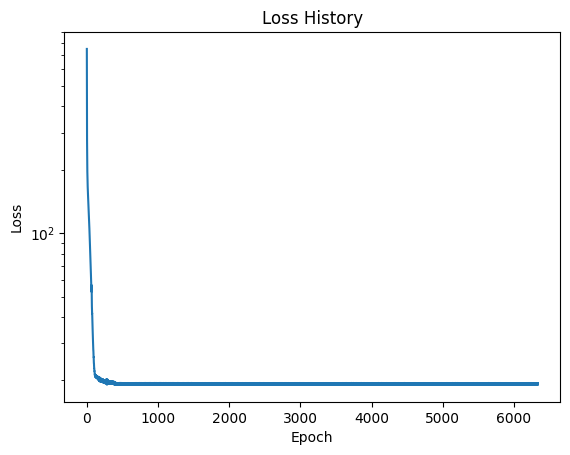

In [ ]:
print(f"par: {model.func.par}")

plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.plot(loss_history)

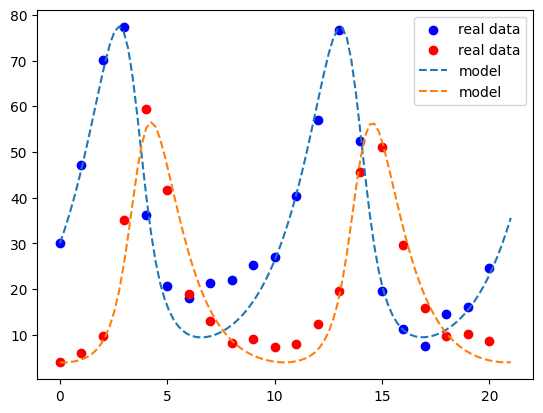

In [ ]:
ts = jnp.arange(0,21,1)

plt.scatter(ts,data[:,0],color = 'blue',label = 'real data')
plt.scatter(ts,data[:,1],color = 'red',label = 'real data')
plt.plot(jnp.linspace(0,21,100),model(jnp.linspace(0,21,100),data[0,:]),'--',label = 'model')
plt.legend()

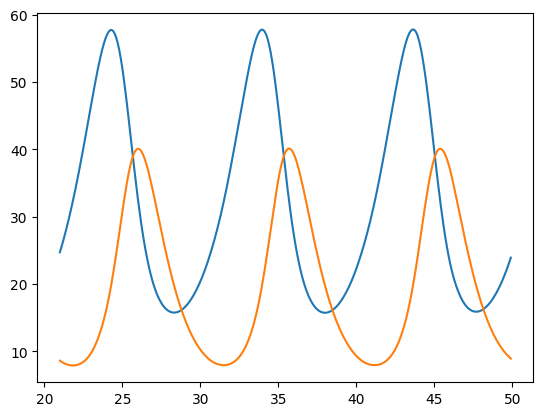

In [ ]:
###Forecast 

ts = jnp.arange(21,50,0.1)
forecast = model(ts,data[-1,:])

plt.plot(ts,forecast)
